# Forex direction predictor

This project is a proof-of-concept of how historical forex data can be used to determine the direction of the price (UP/DOWN) using deep learning.
We use historical EURUSD data from 2021-2023 to train, validate and test a model which predicts the direction of new data better than chance (65% accuracy in the test set).

Note that the model shown here is quite simple and much more can be done to improve the results.For more information and more advanced models contact me at omcandido(at)gmail.com.

In [1]:
from utils.dataset import *
from utils.model import *
from utils.utils import *

import pathlib
import plotly.graph_objects as go
from torchvision import transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


## The historical data
The folder `eurusd` contains the 1-min OHLC (Open, High, Low, Close) ticks of the EUR/USD forex pair from 2015 to 2023. The historical data has been downloaded from [HistData.com](https://www.histdata.com/).

Let's load the data corresponding to the 2020 year and plot the first week of data using 15min candlesticks.

In [2]:
PAIRS_PATH = pathlib.Path.cwd().resolve() / "eurusd"
MODELS_PATH = pathlib.Path.cwd().resolve() / "saved_models"

ticks, epochs = csv_to_ticks([f'{PAIRS_PATH}/DAT_ASCII_EURUSD_M1_2020.zip'])
window = 60*24*7
candle_width = 60
candlesticks = ticks_to_candlesticks(ticks[:window], candle_width)

datetime = pd.to_datetime(epochs, unit='s')
datetime = datetime[range(0, window, candle_width)]


fig = go.Figure(data=[go.Candlestick(x=datetime,
                open=candlesticks[:, OHLC.OPEN],
                high=candlesticks[:, OHLC.HIGH],
                low=candlesticks[:, OHLC.LOW],
                close=candlesticks[:, OHLC.CLOSE])])

fig.show()

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Sorting data...
Done!


The figure above shows the EURUSD rate between Jan 2 and Jan 10 of 2020. We can observe a gap between Jan 4 to Jan 5, due to FOREX being closed on weekends.

## Preprocessing
In order to work with these data we need to create examples our model can learn from. That can be achieved by iteratively going through a window of past ticks and noting how the price fluctuated in the past. We do not want our samples to contain very exhaustive data (i.e., long noisy sequences) but we do not want to do too much preprocessing of the data either because we want our model to figure out the best features on its own.
As a proof of concept, we will be looking at samples with the following parameters:
- `N_PAST`: number of past ticks the model uses to make a prediction. In our case we will be looking at sliding windows containing 1440 ticks (i.e.: the last 24h).
- `TOLERANCE`: becase the dataset contains missing ticks (not only due to the market being closed), we want to be flexible regarding how much data can be missing. We use a value of 0.9, meaning that we require that 90% of the data be present in the `N_PAST` interval.
- `CANDLE_WIDTH`: to understample our data and filter out noise, we look at series of candles of width `CANDLE_WIDTH`. In our case we use candles of width 15 mins.
- `HORIZON`: how long in the future do we want to predict the price movement? We will look at the target price after 720 ticks (i.e.: 12h).
- `THRESHOLD`: how much does the price need to go up/down with respect to the current price in order for it to be considered a positive example? In our case, we consider it a positive example when the price has moved up (down) by a magnitude of 0.003 (i.e., 30 pips), with respect to the highest (lowest) value of the last tick of the ticks window.

In order to make the samples stationary, instead of using the raw OHLC values, we will look at the difference of the current tick values with respect to the OPEN price of the next tick. This will reduce the effects of low frequency signals and help keep the inputs within the same range (i.e., using a candle with of 15 mins, most of the times the price will have moved less than 20 pips).

In [3]:
N_PAST = 60*24     # 1440 ticks
HORIZON = 720      # 12 hours
TOLERANCE = 0.8    # 80% of of the data must be present
CANDLE_WIDTH = 15  # 15 minutes
THRESHOLD = 30e-4  # 30 pips

train_files = [f'{PAIRS_PATH}/DAT_ASCII_EURUSD_M1_2021.zip']
valid_files = [f'{PAIRS_PATH}/DAT_ASCII_EURUSD_M1_2022.zip']
test_files  = [f'{PAIRS_PATH}/DAT_ASCII_EURUSD_M1_2023.zip']

In [4]:
train_dataset = TicksDataset(train_files,
                            N_PAST,
                            HORIZON,
                            TOLERANCE,
                            transform=transforms.Compose([
                                ToCandlesticks(CANDLE_WIDTH),
                                FlipAxes(),
                                ToPipDifference()
                            ]),
                            target_transform=transforms.Compose([
                                Threshold(THRESHOLD),
                                ToMulticlass()
                            ]))
valid_dataset = TicksDataset(valid_files,
                            N_PAST,
                            HORIZON,
                            TOLERANCE,
                            transform=transforms.Compose([
                                ToCandlesticks(CANDLE_WIDTH),
                                FlipAxes(),
                                ToPipDifference(),
                            ]),
                            target_transform=transforms.Compose([
                                # Threshold(THRESHOLD), # Only interested in direction, so no threshold
                                ToMulticlass(),
                            ]))
test_dataset = TicksDataset(test_files,
                            N_PAST,
                            HORIZON,
                            TOLERANCE,
                            transform=transforms.Compose([
                                ToCandlesticks(CANDLE_WIDTH),
                                FlipAxes(),
                                ToPipDifference(),
                            ]),
                            target_transform=transforms.Compose([
                                # Threshold(THRESHOLD), # Only interested in direction, so no threshold
                                ToMulticlass()
                            ]))


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Sorting data...
Done!


100%|██████████| 367282/367282 [00:05<00:00, 68545.50it/s]


Samples identified: 254592 (68.9126%).


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Sorting data...
Done!


100%|██████████| 370645/370645 [00:04<00:00, 77366.99it/s]


Samples identified: 259642 (69.6455%).


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Sorting data...
Done!


100%|██████████| 320418/320418 [00:02<00:00, 112897.50it/s]

Samples identified: 143127 (44.3697%).


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=5)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=6)

### Visual inspection

Let's take one batch from the training data and see what the distribution of the input values and labels look like:

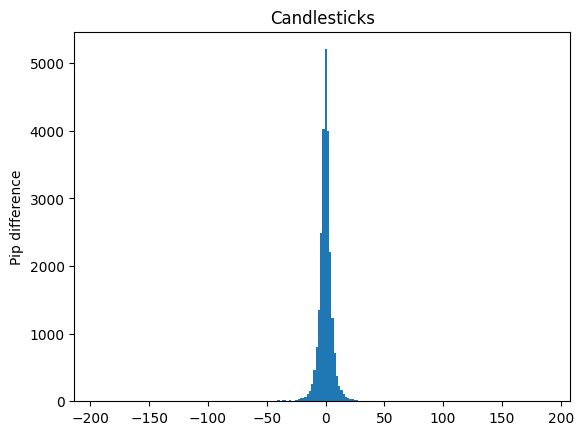

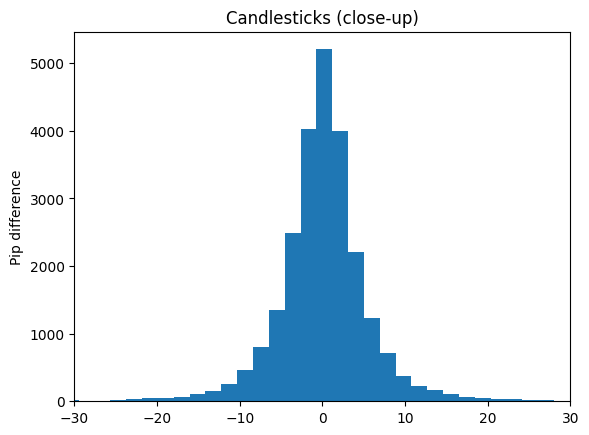

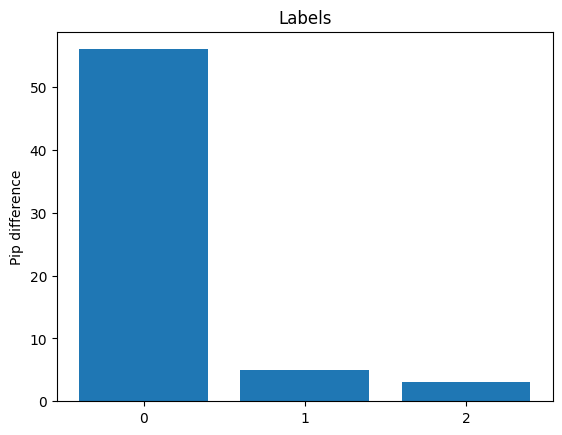

In [6]:
x, y = next(iter(train_dataloader))

plt.hist(x.numpy().flatten(), bins=200)
plt.title('Candlesticks')
plt.ylabel('Pip difference')
plt.show()

plt.hist(x.numpy().flatten(), bins=200)
plt.title('Candlesticks (close-up)')
plt.ylabel('Pip difference')
plt.xlim(-30, 30)
plt.show()

plt.hist(y.numpy().flatten(), bins=np.arange(-0.5, 2.5+1, 1),rwidth=0.8)
plt.title('Labels')
plt.ylabel('Pip difference')
plt.xticks([0, 1, 2])
plt.show()

The two first figures represent the distribution of pip differences in the window of past ticks. We can see that the data is concentrated around the 0 (this makes sense, as we market movements are expected to be (quasi-)random). We confirm the observation made earlier that most tick value diffrences fall within the (+20, -20) pips range.

The last figure tells us that in most of the cases, the price movement resulted in a positive observation—it went up (down) above (below) the threshold.


## Training

We train a 1D-CNN using early stopping and reducing the LR after reaching a plateau according to the parameters below. 

In [7]:
STOP_PATIENCE = 200
PLATEAU_PATIENCE = STOP_PATIENCE // 4

model = ConvNetMultiClass(N_PAST//CANDLE_WIDTH).to(DEVICE)


criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 50, 50], dtype=torch.float32).to(DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=PLATEAU_PATIENCE, threshold=1e-3, threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-8)


In [8]:
train_losses = []
valid_losses = []

# Train the model
total_steps = len(train_dataloader)
bad_epochs = 0
best_loss = np.inf
iter_valid_dataloader = iter(valid_dataloader)
for epoch in range(100):
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        x_batch = x_batch.to(torch.float32).to(DEVICE)
        x_batch = x_batch.to(torch.float32).to(DEVICE)
        y_batch = y_batch.to(DEVICE).type(torch.int64)
        
        # Forward pass
        model.train()
        preds = model(x_batch)
        train_loss = criterion(preds, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        avg_train_loss = sum(train_losses[-100:])/len(train_losses[-100:])
        
        model.eval()
        with torch.no_grad():
            try:
                x_batch, y_batch =  next(iter_valid_dataloader)
            except StopIteration:
                iter_valid_dataloader = iter(valid_dataloader)
                x_batch, y_batch =  next(iter_valid_dataloader)
            
            x_batch = x_batch.to(torch.float32).to(DEVICE)
            x_batch = x_batch.to(torch.float32).to(DEVICE)
            y_batch = y_batch.to(DEVICE).type(torch.int64)
                            
            preds = model(x_batch)
            
            valid_loss = criterion(preds, y_batch)
            valid_losses.append(valid_loss.item())
            
            avg_valid_loss = sum(valid_losses[-100:])/len(valid_losses[-100:])
            
            scheduler.step(valid_loss)
            
            print ('Epoch [{}/{}], Step [{}/{}], Train loss: {:.4f}, Valid loss: {:.4f}'
                            .format(epoch+1, 100, i+1, total_steps, train_loss.item(), avg_valid_loss))
            
            
            torch.save(model.state_dict(), f"{MODELS_PATH}/model.pt")
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                bad_epochs = 0
                torch.save(model.state_dict(), f"{MODELS_PATH}/model.pt")
            else:
                bad_epochs += 1
                print(f"Bad epochs: {bad_epochs} · Best loss: {scheduler.best:.4f} · LR: {scheduler.optimizer.param_groups[0]['lr']}")
                if bad_epochs > STOP_PATIENCE:
                    break
                
    else:
        continue
    break

Epoch [1/100], Step [1/3978], Train loss: 1.1559, Valid loss: 1.0669
Epoch [1/100], Step [2/3978], Train loss: 1.0281, Valid loss: 1.0561
Epoch [1/100], Step [3/3978], Train loss: 0.9412, Valid loss: 1.0440
Epoch [1/100], Step [4/3978], Train loss: 0.9182, Valid loss: 1.0360
Epoch [1/100], Step [5/3978], Train loss: 0.9467, Valid loss: 1.0261
Epoch [1/100], Step [6/3978], Train loss: 0.9087, Valid loss: 1.0179
Epoch [1/100], Step [7/3978], Train loss: 0.9526, Valid loss: 1.0087
Epoch [1/100], Step [8/3978], Train loss: 0.9440, Valid loss: 1.0007
Epoch [1/100], Step [9/3978], Train loss: 0.8398, Valid loss: 0.9923
Epoch [1/100], Step [10/3978], Train loss: 0.8803, Valid loss: 0.9845
Epoch [1/100], Step [11/3978], Train loss: 0.8832, Valid loss: 0.9759
Epoch [1/100], Step [12/3978], Train loss: 0.9339, Valid loss: 0.9681
Epoch [1/100], Step [13/3978], Train loss: 1.0714, Valid loss: 0.9611
Epoch [1/100], Step [14/3978], Train loss: 1.2826, Valid loss: 0.9538
Epoch [1/100], Step [15/3978]

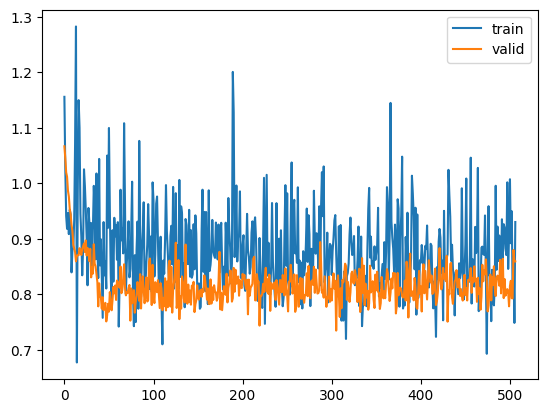

In [9]:
# This is what the training and validation losses look like:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

In [10]:
# Load the best trained model
model = ConvNetMultiClass(N_PAST//CANDLE_WIDTH).to(DEVICE)
model.load_state_dict(torch.load(f"{MODELS_PATH}/model.pt"))

<All keys matched successfully>

In [11]:
counts_ = []
for x_batch, y_batch in test_dataloader:
    model.eval()
    with torch.no_grad():
        x_batch = x_batch.to(DEVICE)
        x_batch = x_batch.to(torch.float32).to(DEVICE)
        y_batch = y_batch.to(DEVICE).type(torch.int64)
               
        preds = model(x_batch)

        metrics, counts = metrics_batch(preds, y_batch, 0.6)
        
        counts_.append(counts[0][1][1]) # TP class 0
        counts_.append(-counts[0][0][1]) # FP class 0
        counts_.append(counts[1][1][1]) # TP class 1
        counts_.append(-counts[1][0][1]) # FP class 1

total = sum([abs(c) for c in counts_])
pos = sum([c for c in counts_ if c > 0])
net = sum(counts_)

print('Of out {} trades, {:.2%} were successful (net: {} successful trades)'.format(total, pos/total, net))

Of out 9184.0 trades, 64.69% were successful (net: 2698.0 successful trades)


## Conclusion
In this notebook we train a machine learning model to predict the direction of the market after a given time horizon based exclusively on a window of past ticks.

We show that we can predict new labels with an accuracy above chance (65% accuracy in the test set), a remarkable performance considering that the model takes about just one minute to be trained from scratch. This suggests that pure technical analysis of historic FOREX data can indeed predict future short-term performance.

Now, will you get rich using this model? **Absolutely not**. One of the reasons for that is that this naive model only predicts the market direction and does not take the reward-to-risk ratio into consideration.